# Training static Digital Backpropogation (DBP) variants with adaptive equalizer layers
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/remifan/commplax/blob/master/docs/tutorial/stateful_layer.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/remifan/commplax/HEAD?labpath=docs%2Ftutorial%2Fstateful_layer.ipynb)

```
                       ▲                       ▲
                       │                       │
       ┌───────┐   ┌───┴───┐    ┌──────┐   ┌───┴────┐
──────►│  DBP  ├──►│  FOE  ├─┬─►│ Conv ├──►│  MIMO  ├───┬─┬─►
       └───────┘   └───┬───┘ │  └──────┘   └───┬────┘   │ │
           ▲           │     │     ▲           │        │ │
           │        adaptive │     │        adaptive    │ │
       backprop        │     │  backprop       │        │ │
           │           └─────┘     │           └────────┘ │
           │                       │                      │
           └───────────────────────┴──────────────────────┘
```

## Install and import dependencies

In [1]:
# install Jax if not found
try:
  import jax
except ModuleNotFoundError:
  %pip install --upgrade "jax[cpu]"
  # %pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_releases.html  # Note: wheels only available on linux.

# install commplax if not found
try:
  import commplax
except ModuleNotFoundError:
  %pip install --upgrade https://github.com/remifan/commplax/archive/master.zip

# install data api if not found
try:
  import labptptm2
except ModuleNotFoundError:
  %pip install https://github.com/remifan/LabPtPTm2/archive/master.zip


# install GDBP if not found
try:
  import gdbp
except ModuleNotFoundError:
  %pip install https://github.com/remifan/gdbp_study/archive/master.zip

In [2]:
import numpy as np
from tqdm.auto import tqdm
from functools import partial
import matplotlib.pyplot as plt

from commplax import util, comm
from gdbp import gdbp_base as gb, data as gdat, aux

## Loading data from LabPtPTm2 datasets

In [3]:
# get 2 received waveforms@0dBm with different random sequence
# Note: see https://github.com/remifan/LabPtPTm2 for details

ds_train, ds_test = gdat.load(1, 0, 4, 1)[0], gdat.load(2, 0, 4, 1)[0]

loading data:   0%|          | 0/1 [00:00<?, ?it/s]

loading data:   0%|          | 0/1 [00:00<?, ?it/s]

## Initializing models

In [4]:
# Note: see `https://github.com/remifan/gdbp_study/blob/master/gdbp/gdbp_base.py` for model definition

def init_models(data: gdat.Input, **kwargs):
  ''' make CDC and DBP's derivatives
      (all methods has trainable R-filter)
      cdc:  static D-filter, no NLC
      dbp:  static D-filter, scalar manually optimized NLC factor
      fdbp: static D-filter, static N-filter scaled by manually optimized NLC factor
      edbp: static D-filter, tap-by-tap optimizable/trainable N-filter
      gdbp: tap-by-tap optimizable/trainable D-filter and N-filter
  '''
  
  mode  = kwargs.get('mode', 'train')
  steps = kwargs.get('steps', 3)
  dtaps = kwargs.get('dtaps', 261)
  ntaps = kwargs.get('ntaps', 41)
  rtaps = kwargs.get('rtaps', 61)
  xi    = kwargs.get('xi', 1.1) # optimal xi for FDBP
  
  fdbp_init = partial(gb.fdbp_init, data.a, steps=steps)
  model_init = partial(gb.model_init, data)
  
  comm_conf = {'mode': mode, 'steps': steps, 'dtaps': dtaps, 'rtaps': rtaps} # common configurations
  #     init. func.| define model structure parameters and some initial values    | define static modules    | identifier
  cdc  = model_init({**comm_conf, 'ntaps': 1,     'init_fn': fdbp_init(xi=0.0)},  [('fdbp_0',)],             name='CDC')
  dbp  = model_init({**comm_conf, 'ntaps': 1,     'init_fn': fdbp_init(xi=0.15)}, [('fdbp_0',)],             name='DBP')
  fdbp = model_init({**comm_conf, 'ntaps': ntaps, 'init_fn': fdbp_init(xi=xi)},   [('fdbp_0',)],             name='FDBP')
  edbp = model_init({**comm_conf, 'ntaps': ntaps, 'init_fn': fdbp_init(xi=xi)},   [('fdbp_0', r'DConv_\d')], name='EDBP')
  gdbp = model_init({**comm_conf, 'ntaps': ntaps, 'init_fn': fdbp_init(xi=xi)},   [],                        name='GDBP')
  
  return cdc, dbp, fdbp, edbp, gdbp


models_train = init_models(ds_train)
models_test = init_models(ds_test, mode='test')

## Training and testing all models

In [5]:
results = []

for model_train, model_test in tqdm(zip(models_train, models_test), total=5, desc='sweep models'):
  # use trained params of the 3rd last batch, as tailing samples are corrupted by CD
  params_queue = [None] * 3
  
  for _, p, _ in gb.train(model_train, ds_train, n_iter=2000):
    params_queue.append(p)
    params = params_queue.pop(0)

  results.append(gb.test(model_test, params, ds_test, metric_fn=comm.qamqot_local)[0])

sweep models:   0%|          | 0/5 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

training:   0%|          | 0/2000 [00:00<?, ?it/s]

## Results

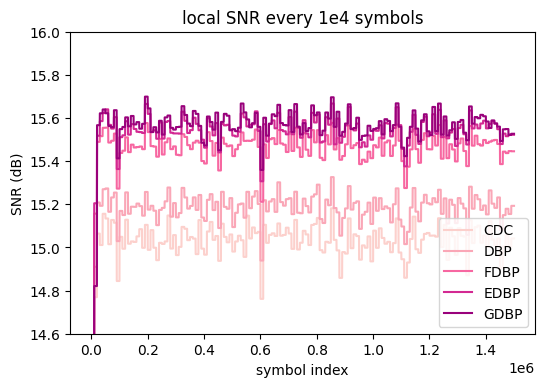

In [6]:
import matplotlib.pyplot as plt

labels = ['CDC', 'DBP', 'FDBP', 'EDBP', 'GDBP']
colors = plt.cm.RdPu(np.linspace(0.2, 0.8, len(labels)))

fig = plt.figure(dpi=100)
for r, l, c in zip(results, labels, colors):
  plt.plot(r['SNR'][:, 2], label=l, color=c) # averaged SNR of Pol. X and Pol. Y
plt.title('local SNR every 1e4 symbols')
plt.xlabel('symbol index')
plt.ylabel('SNR (dB)')
plt.ylim([14.6, 16.])
plt.legend(loc='lower right')

Check our [reserch artical](https://remifan.github.io/gdbp_study/article.html) for complete content.